# volmc demo

In [1]:
from volmc.models import BlackScholes, Heston, Dupire
from volmc.schemes import Euler, QE
from volmc.types import *
from volmc.options import Call, Put, DigitalCall, DigitalPut, Instrument 

import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
plt.style.use("dark_background")

## Creating an instrument

In [3]:
from volmc.options import Instrument, OptionContract, CallPayoff, PutPayoff, BarrierPayoff

Instruments can be created from a contract and a payoff :

In [4]:
contract = OptionContract(K = 110, T = 1.5)

call_option = Instrument(contract, CallPayoff())
put_option = Instrument(contract, PutPayoff())

in_out_payoff = BarrierPayoff(H = 120, direction = "up", nature = "out", payoff = CallPayoff())
in_out_call = Instrument(contract, in_out_payoff)

For convenience, some functions allow to rapidely create a predefined instrument :

In [5]:
from volmc.options import Call, Put, DigitalCall, DigitalPut

In [6]:
call_option = Call(K = 110, T = 1.5)
digital_put = DigitalPut(K = 90, T = 1.5)

## Generating a path

### Parametrize a model

In [7]:
from volmc.models import BlackScholes, Heston, Dupire
from volmc.types import LocalVolatilitySurface

In [8]:
bs = BlackScholes(mu = 0.02, sigma = 0.2)
heston = Heston(mu = 0.02,
                kappa = 1.5,
                theta = 0.05,
                epsilon = 0.2,
                rho = -0.5)

### Dupire

In [9]:
s = [80, 90, 100, 110, 120]
t = [0.2, 0.4, 0.8, 1.0]
v = [
# S = 80 |  90  | 100 | 110 | 120    t =  
    [0.32, 0.26, 0.22, 0.25, 0.30],  # 0.2
    [0.30, 0.25, 0.21, 0.24, 0.28],  # 0.4
    [0.28, 0.24, 0.20, 0.23, 0.26],  # 0.8
    [0.26, 0.23, 0.19, 0.22, 0.25],  # 1.0
    ]


In [10]:
surface = LocalVolatilitySurface(t, s, v)
surface.sigma(0.3, 84) #interpolation ex

0.288

In [11]:
dupire = Dupire(r = 0.03,
                q = 0.01,
                local_volatility_surface=surface)

### Discretization scheme

In [12]:
from volmc.schemes import Euler, QE

In [13]:
euler_black_scholes = Euler(bs)

euler_dupire = Euler(dupire)

qe = QE(heston)

### Engine

In [14]:
from volmc.pricing import MonteCarlo, BlackScholesEngine, HestonEngine

#### QE

In [15]:
qe_engine = MonteCarlo(qe)
qe_engine.configure(seed = 1 , n_jobs = -1) #n_jobs = -1 uses all available cores

In [16]:
# Alternatively :
qe_engine = HestonEngine(mu = 0.02, kappa = 1.5, theta = 0.05, epsilon = 0.2, rho = -0.5, scheme = "qe")
qe_engine.configure(1, -1)

In [17]:
heston_sim = qe_engine.generate(S0 = 100,
                n = 252,
                T = 1,
                n_paths = 100,
                v0 = 0.2)

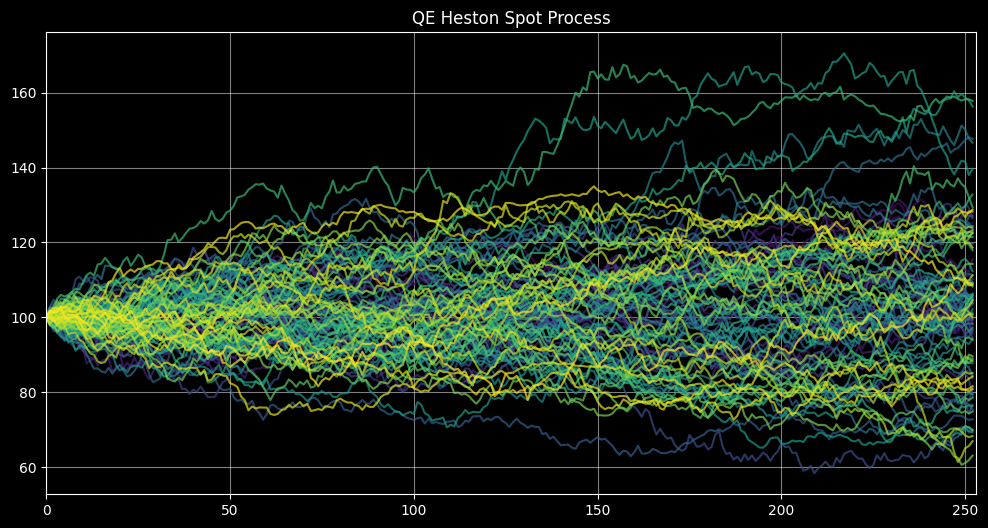

In [18]:
S = heston_sim.spot_values()

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, 100)]
plt.figure(figsize=(12, 6))
for i, s in enumerate(S):
    plt.plot(s, color = colors[i], alpha=0.7)
plt.grid(alpha = 0.5)
plt.xlim(0, 253)
plt.title("QE Heston Spot Process")
plt.show()

#### Euler and Dupire

In [19]:
dupire_engine = MonteCarlo(euler_dupire)
dupire_engine.configure(2, -1)

In [20]:
dp_sim = dupire_engine.generate(100, 252, 1, 100)

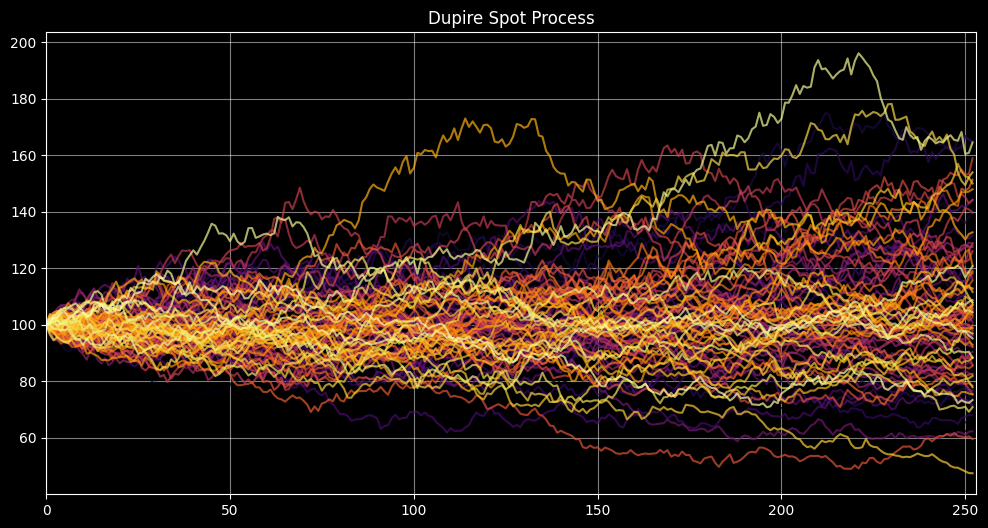

In [21]:

cmap = plt.get_cmap('inferno')
colors = [cmap(i) for i in np.linspace(0, 1, 100)]
plt.figure(figsize=(12, 6))
for i, s in enumerate(dp_sim.spot_values()):
    plt.plot(s, alpha=0.7, color = colors[i])
plt.grid(alpha = 0.5)
plt.xlim(0, 253)
plt.title("Dupire Spot Process")
plt.show()

## Pricing

In [22]:
from volmc.pricing import Pricer
from volmc.types import MarketState

from scipy.stats import norm

In [23]:
def get_d1(S, K, sigma, T, r):
    return (np.log(S/K) + ((sigma**2)/2 + r)*T)/(sigma*np.sqrt(T))

def bs_call_price(S, K, sigma, T, r):
    d1 = get_d1(S, K, sigma, T, r)
    d2 = d1 - np.sqrt(T)*sigma

    return S* norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def bs_put_price(S, K, sigma, T, r):
    d1 = get_d1(S, K, sigma, T, r)
    d2 = d1 - np.sqrt(T)*sigma

    return -S* norm.cdf(-d1) + K*np.exp(-r*T)*norm.cdf(-d2)

def bs_delta_call(S, K, sigma, T, r):
    d1 = get_d1(S, K, sigma, T, r)
    return norm.cdf(d1)

def bs_delta_put(S, K, sigma, T, r):
    d1 = get_d1(S, K, sigma, T, r)
    return -norm.cdf(-d1)

def gamma(S, K, sigma, T, r):
    d1 = get_d1(S, K, sigma, T, r)
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    return gamma

### Call option

In [24]:
r = 0.02
S0 = 110
v0 = 0.25
K = 120
T = 1.4

In [25]:
euler_bs = Euler(BlackScholes(r, v0))
bs_engine = MonteCarlo(euler_bs)
bs_engine.configure(seed = 1, n_jobs = -1)

call = Call(K, T)
marketstate = MarketState(S0, r)

p = Pricer(marketstate, n_steps = 252, n_paths= 100_000, engine =bs_engine)

mc_price = p.price(call)
bs_price = bs_call_price(S0, K, v0,  T, r)

mc_delta = p.delta(call, h = 0.01)
bs_delta = bs_delta_call(S0, K , v0 , T, r)

In [26]:
mc_gamma = p.gamma(call, h = 0.01)
bs_gamma = gamma(S0, K , v0 , T, r)

In [27]:
print(f"Black Scholes analytical price : {bs_price:.4f}")
print(f"Monte Carlo simulation price : {mc_price:.4f}")

Black Scholes analytical price : 10.2459
Monte Carlo simulation price : 10.3168


In [28]:
print(f"Black Scholes analytical delta : {bs_delta:.4f}")
print(f"Monte Carlo simulation delta : {mc_delta:.4f}")

Black Scholes analytical delta : 0.4794
Monte Carlo simulation delta : 0.4816


In [29]:
print(f"Black Scholes analytical gamma : {bs_gamma:.4f}")
print(f"Monte Carlo simulation gamma : {mc_gamma:.4f}")

Black Scholes analytical gamma : 0.0122
Monte Carlo simulation gamma : 0.0098


### Digital Put

In [30]:
r = 0.01
S0 = 105
v0 = 0.3
K = 125
T = 1.7

In [31]:
qe = QE(Heston(mu = r,
                kappa = 1.5,
                theta = 0.05,
                epsilon = 0.2,
                rho = -0.5))

qe_engine = MonteCarlo(qe)
qe_engine.configure(seed = 1 , n_jobs = -1)

In [32]:
digital_put = DigitalPut(K = K, T = T)
state = MarketState(S = S0, r = r, v0 = v0)

engine = Pricer(state, 252, 100_000, qe_engine)

In [33]:
digital_price = engine.price(digital_put)

In [34]:
print(f"Heston estimated digital put price : {digital_price:.4f}")

Heston estimated digital put price : 0.7122


### Barrier option

In [35]:
r = 0.02
v0 = 0.2
S0 = 100
K = 110
H = 140

In [36]:
up_out_payoff = BarrierPayoff(H, "up", "out", CallPayoff())
up_out_call = Instrument(OptionContract(K = K, T = 1), up_out_payoff)

In [37]:
euler_bs = Euler(BlackScholes(r, v0))
bs_engine = MonteCarlo(euler_bs)
bs_engine.configure(seed = 1, n_jobs = -1)

In [38]:
marketstate = MarketState(S0, r)

p = Pricer(marketstate, 1000, 10_000, bs_engine)
price = p.price(up_out_call)

In [39]:
print(f"Estimated Monte Carlo price for this up-and-out call option : {price:.4f}")

Estimated Monte Carlo price for this up-and-out call option : 2.1837


### Batch Pricing

Price multiple options from a same simulation : 

In [40]:
T = 1.2
r = 0.02
S0 = 100

call_105 = Call(105, T)
call_92 = Call(92, T)
call_110 = Call(110, T)

put_105 = Put(105, T)
put_92 = Put(92, T)
put_110 = Put(110, T)

digi_call_107 = DigitalCall(107, T)
digi_put_107 = DigitalPut(107, T)


in_list = [call_105, call_92, call_110, put_105, put_92, put_110, digi_call_107, digi_put_107]

In [41]:
mc = BlackScholesEngine(0.02, 0.2)
mc.configure(1, -1)

ms = MarketState(S0, r)

engine = Pricer(ms, 252, 100_000, mc)

In [42]:
prices = engine.batch_price(in_list)
print(prices)

[7.677609682895932, 14.418038944821866, 5.860376924775665, 10.078080185562353, 4.126795220635833, 13.14227597623177, 0.370861652565737, 0.6054240571921723]
